# ECE 763 Project 01: Training Multi-Layer Perceptrons and Convoluational Neural Networks on CIFAR10


Objectives:

- To get hands-on experiences on working with images (CIFAR10) and neural networks by implementing multi-layer perceptrons (MLPs) and convolutional neural networks (ConvNets).
- To test different regularization strategies to get the best performance out of your models.
- To investigate the limitations of using MLPs in this task, compared with ConvNets.
- To investigate the potential risk of fitting noise of both MLPs and ConvNets.


### What to Do?

* Assume you have installed the ece763 environment. Run this notebook with that environment.
* Write your code and text for all TODOs as shown by:

```python
    # TODO: ??? points - descriptions of what to do
    raise NotImplementedError # comment it out after you write your code
```

### How to submit your solutions

* Add your NCSU ID as the postfix of the notebook filename, e.g., `Project_01_MLPs_ConvNets_twu19.ipynb`
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_01_MLPs_ConvNets_twu19_results.ipynb`), and the other with all outputs cleared (`Project_01_MLPs_ConvNets_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former.

* Late policy:  5 free late days (counted using 0.5 unit, <=6 hours as 0.5 late day, otherwise 1 later day) in total – use them in your ways; Afterwards, 25% off per day late; Not accepted after 3 late days per HW and Project. Not applicable to the final project.
* Important Note: We will NOT accept any replacement of submission after deadline, even if you can show the time stamp of the replacement is earlier than the deadline. So, please double-check if you submit correct files.
* Academic Integrity: Students are required to comply with the university policy on academic integrity found in the Code of Student Conduct found at http://policies.ncsu.edu/policy/pol-11-35-01
* Academic Honesty: See http://policies.ncsu.edu/policy/pol-11-35-01  for a detailed explanation of academic honesty.


## Import libraries to be Used

In [1]:
## Standard libraries
import os
import json
import math
import random
import numpy as np
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
pip install mmengine==0.10.3

### Identify the system


In [3]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: 8efaa31513f4
Release: 6.1.58+
Version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python', '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'),
             ('CUDA available', False),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GCC',
              'x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.1.0+cu121'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
              '  - C++ Version: 201703\n'
              '  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product '
              'Build 202

## Set Random Seeds and Devices

In [4]:
# Function for setting the seed
def random_seed(seed: int = 42, rank: int = 0, deterministic: bool = False) -> None:
    # TODO: 2 points  - write your code below
    #raise NotImplementedError # comment it out after you write your code
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed + rank)
        torch.cuda.manual_seed_all(seed + rank)

        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = True

seed = 42
random_seed(seed=seed, deterministic=True)

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cpu


## Prepare Datasets (CIFAR10)

In [5]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoints/ece763_proj_01"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### CIFAR10
CIFAR10 is a very popular dataset for computer vision on low-resolution images (32x32 pixels). The task is to classify images into one of 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**.

In [6]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

# Transformations are applied on images when we want to access them. Here, we push the images into a tensor
# and normalize the values. However, you can use more transformations, like augmentations to prevent overfitting.
# Feel free to experiment with augmentations here once you have a first running MLP, but remember to not apply
# any augmentations on the test data!
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Loading the training dataset. We need to split it into a training and validation part
main_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms, download=True)
train_set, val_set = torch.utils.data.random_split(main_dataset, [45000, 5000], generator=torch.Generator().manual_seed(seed))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=data_transforms, download=True)

# Create data loaders for later
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

# classes
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


When working with data, it is always recommend to look at the data before blaming your model for not performing well if the data was incorrectly processed. Hence, let's plot 1-batch images of the CIFAR10 training dataset:

In [7]:
start_time = time.time()
dataiter = iter(train_loader)
images, labels = next(dataiter)
end_time = time.time()
print(f"Time for loading a batch: {(end_time - start_time):6.5f}s")

Time for loading a batch: 0.29895s


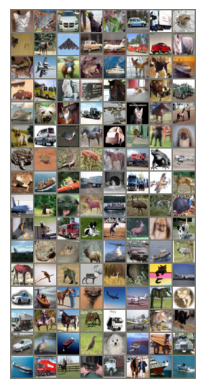

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [8]:
INV_DATA_MEANS = torch.tensor([-m for m in DATA_MEANS]).view(-1, 1, 1)
INV_DATA_STD = torch.tensor([1.0 / s for s in DATA_STD]).view(-1, 1, 1)

def imshow(img):
    img = img.div_(INV_DATA_STD).sub_(INV_DATA_MEANS) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    plt.close()


imshow(torchvision.utils.make_grid(images))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

Now we are all set. So, let's dive into implementing our own MLP and ConvNet!

## Part 0: Optimizer

To gain a better insight in the training of the neural networks, let's implement our own optimizer. First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps.

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function `zero_grad` sets the gradients of all parameters to zero, which we have to do before calling `loss.backward()`. Finally, the `step()` function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [9]:
class OptimizerTemplate:

    def __init__(self, params: nn.ParameterList, lr: float)->None:
        self.params = list(params)
        self.lr = lr

    def zero_grad(self)->None:
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self)->None:
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p: nn.Parameter)->None:
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD) with momentum. Plain SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

The concept of momentum replaces the gradient in the update by an exponential average of all past gradients including the current one, which allows for a smoother training. The gradient update with momentum becomes:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's implement the optimizer below:

In [10]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params: nn.ParameterList, lr: float, momentum: float=0.9)->None:
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p:nn.Parameter)->None:
        # TODO: 10 points -- Implement the gradient update
        #raise NotImplementedError
        if p.grad is None:
            return
        grad = p.grad.data
        if self.momentum != 0:

            self.param_momentum[p] = self.momentum * self.param_momentum[p] + (1 - self.momentum) * grad

            p.data -= self.lr * self.param_momentum[p]



To verify that our optimizer is working, let's create a challenging surface over two parameter dimensions which we want to optimize to find the optimum:

In [11]:
def pathological_curve_loss(w1: float, w2: float) -> float:
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

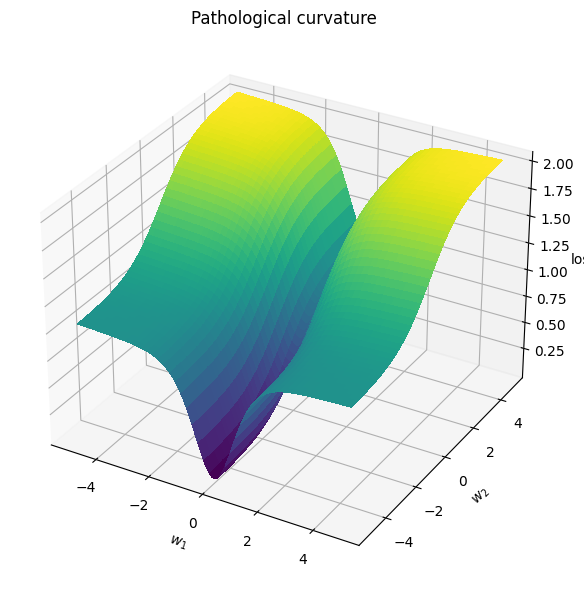

In [12]:
def plot_curve(curve_fn, x_range: Tuple[float, float] = (-5,5), y_range: Tuple[float, float]=(-5,5), plot_3d: bool=False, cmap=cm.viridis, title: str="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d") if plot_3d else fig.add_subplot()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y], indexing='ij')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [13]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        # TODO: 8 points -- Determine the loss for the current weights, save the weights and loss, perform backpropagation
        #raise NotImplementedError
        loss = curve_func(weights[0], weights[1])


        list_points.append(torch.tensor([weights[0].item(), weights[1].item(), loss.item()]))

        optimizer.zero_grad()
        loss.backward()


        optimizer.step()



    points = torch.stack(list_points, dim=0).detach().cpu().numpy()
    return points

Next, let's apply the optimizer on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [14]:
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
print(SGDMom_points)

[[ 5.00000000e+00  5.00000000e+00  2.04312563e+00]
 [ 4.98963690e+00  4.99335194e+00  2.04297376e+00]
 [ 4.96993923e+00  4.98067713e+00  2.04268408e+00]
 [ 4.94182587e+00  4.96249342e+00  2.04226732e+00]
 [ 4.90611601e+00  4.93922949e+00  2.04173279e+00]
 [ 4.86353874e+00  4.91123343e+00  2.04108715e+00]
 [ 4.81474257e+00  4.87878084e+00  2.04033566e+00]
 [ 4.76030016e+00  4.84208155e+00  2.03948092e+00]
 [ 4.70071554e+00  4.80128479e+00  2.03852463e+00]
 [ 4.63642836e+00  4.75648212e+00  2.03746605e+00]
 [ 4.56781864e+00  4.70770979e+00  2.03630257e+00]
 [ 4.49520826e+00  4.65494967e+00  2.03502893e+00]
 [ 4.41886282e+00  4.59812975e+00  2.03363800e+00]
 [ 4.33899117e+00  4.53712082e+00  2.03211832e+00]
 [ 4.25574541e+00  4.47173405e+00  2.03045464e+00]
 [ 4.16921663e+00  4.40171528e+00  2.02862811e+00]
 [ 4.07942915e+00  4.32673740e+00  2.02661180e+00]
 [ 3.98633361e+00  4.24638891e+00  2.02437162e+00]
 [ 3.88979340e+00  4.16016054e+00  2.02186131e+00]
 [ 3.78956723e+00  4.06742573e+

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

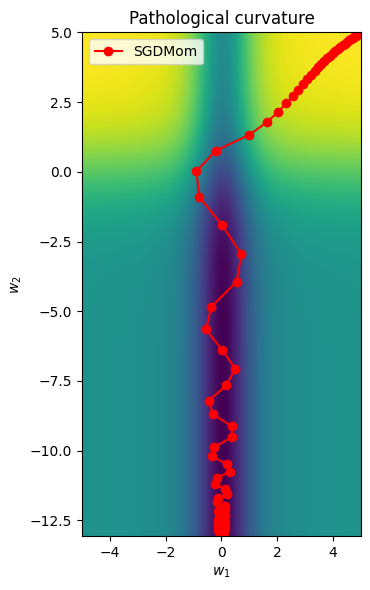

In [15]:
all_points = SGDMom_points
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="red", marker="o", zorder=2, label="SGDMom")
plt.legend()
plt.show()

If the implementation is correct, you should see that the optimizer indeed reaches a point of very low $w_2$ ($w_2 < -7.5$) and $w_1\approx 0$. If not, go back to your optimizer implementation and check what could go wrong.

## Part 1. Generic training and validation function

Now that we the optimizer implemented, and the dataset loaded, we can look at implementing our own training functions.

In [16]:
def train_one_epoch(model: nn.Module, optimizer: OptimizerTemplate, loss_module, data_loader)->Tuple[float, int]:
    true_preds, count = 0.0, 0
    model.train()
    for imgs, labels in data_loader:
        # TODO: 10 points -- Implement training loop with training on classification
        imgs, labels = imgs.to(device), labels.to(device)
         # Zero-grad can be placed anywhere before "loss.backward()"
        preds = model(imgs)
        loss = loss_module(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        true_preds += (preds.argmax(dim=-1) == labels).sum()
        count += labels.shape[0]

        #raise NotImplementedError

        # Record statistics during training

    train_acc = true_preds / count
    return train_acc

In [17]:
@torch.no_grad()
def test_model(model, data_loader):
    # TODO: 10 points - Test model and return accuracy
    #raise NotImplementedError
    if model is None:
        raise ValueError("Model is not initialized.")
    model.eval()
    true_preds, count =0.0,0.0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)  # Forward pass
        #_, preds = torch.max(outputs, 1)  # Get the predicted class
        true_preds += (preds.argmax(dim=-1) == labels).sum()
        count += labels.shape[0]

    accuracy = true_preds / count if count > 0 else 0.0
    return accuracy


In [18]:
def save_model(model, model_name, root_dir=CHECKPOINT_PATH):
    # TODO: 2 points -- Save the parameters of the model
    torch.save(model.state_dict(), os.path.join(root_dir, model_name + '.pt'))
    #raise NotImplementedError


def load_model(model, model_name, root_dir=CHECKPOINT_PATH):
    # TODO: 2 points -- Load the parameters of the model
    model_path = os.path.join(root_dir, model_name + '.pt')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    model.load_state_dict(torch.load(model_path))
    return model
    #raise NotImplementedError


In [19]:
def train_model(model, optimizer, loss_module, train_data_loader, val_data_loader, num_epochs=25, model_name="MyModel"):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs+1):
        train_acc = train_one_epoch(model, optimizer, loss_module, train_data_loader)

        if epoch % 5 == 0 or epoch == num_epochs:
            # Evaluate the model and save if best
            acc = test_model(model, val_data_loader)
            if acc > best_val_acc:
                best_val_acc = acc
                save_model(model, model_name, CHECKPOINT_PATH)

            print(
                f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )

    # Load best model after training
    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model

## Part 2: Implementing the MLP



### Part 2.1: Vanilla MLP Module

You can make use of PyTorch's common functionalities, especially the `torch.nn` modules might be of help. The design choices of the MLP (e.g. the activation function) is left up to you, but for an initial setup, we recommend stacking linear layers with ReLU activation functions in between. Remember to not apply any activation function on the output.

In [20]:
class MLP(nn.Module):

    def __init__(self, input_dim: int=3072, num_classes: int=10, hidden_dims: List[int]=[256, 128], act_layer: nn.Module=nn.ReLU)->None:
        """
        Inputs:
            input_dim - Dimension of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_dims - A list of integers specifying the hidden layer dimensions in the MLP.
                           The MLP should have len(hidden_sizes)+1 linear layers.
            act_layer - Activation function.
        """
        super().__init__()
        # TODO: 5 points - Create the network based on the specified hidden sizes
        layers = []
        in_dim = input_dim
        for out_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(act_layer())
            in_dim = out_dim
        layers.append(nn.Linear(in_dim, num_classes))
        self.layers = nn.Sequential(*layers)
        #raise NotImplementedError

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: 5 points -- Apply the MLP on an input

        x = x.view(x.size(0), -1)
        return self.layers(x)
        #raise NotImplementedError


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

In [22]:
# Let's test the MLP implementation
input_dim = np.random.randint(low=64, high=3072)
num_classes = np.random.randint(low=5, high=20)
hidden_dims = [np.random.randint(low=32, high=256) for _ in range(np.random.randint(low=1, high=3))]
my_mlp = MLP(input_dim=input_dim, num_classes=num_classes, hidden_dims=hidden_dims)
my_mlp.to(device)
random_input = torch.randn(32, input_dim, device=device)
random_output = my_mlp(random_input)
assert random_output.shape[0] == random_input.shape[0]
assert random_output.shape[1] == num_classes

In [23]:
# Create model, optimizer, and start training
model_mlp = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp.parameters(), lr=0.1) # you may tune lr
loss_module = nn.CrossEntropyLoss().to(device)

print(f'model mlp created: {count_parameters(model_mlp):05.3f}M')
model_mlp=train_model(model_mlp, optimizer, loss_module, train_loader, val_loader, num_epochs=5, model_name="myMLP_ReLU")

model mlp created: 0.821M


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch  6] Training accuracy: 57.73%, Validation accuracy: 50.92%, Best validation accuracy: 50.92%


In [24]:
# Test best model on test set
vanilla_mlp_test_acc = test_model(model_mlp, test_loader)
print(f'Test accuracy: {vanilla_mlp_test_acc*100.0:05.2f}%')

Test accuracy: 50.87%


Note: As confirmed with TA, this accuracy also works

It is expected that you reach with the default configurations a validation and test accuracy of $\sim51-53\%$ . If you have reached this performance, we can consider this task as completed!

### Part 2.2: Improving the vanilla MLP

Now that we have a basic MLP, let's try to improve over this default performance! Your task is to think about ways to maximize the performance of your MLP. Possible suggestions you can look at include:

* Do data augmentations help the model to generalize?
* Can regularization techniques (dropout, weight decay, etc.) help?
* Do deeper models perform better? Or is it better to have wide networks?
* Can normalization techniques (BatchNorm, LayerNorm, etc.) help?

Your task is to improve your model to reach at least 56% on the test set! But can you get even above this? Consider this as a challenge!

For this implementation, you can copy and then modify your codes above. List the changes that you have made and discuss what affect they have. Further, repeat the experiments for *at least 3 seeds* to report stable improvements.

*Here, all the 4 mentioned suggestions were tried.*
* Applied data augmentations such as RandomFlip() but it did not increase the efficiency
* Batch size has been reduced
* Dropout was performed but decreased the efficiency
* Deeper models perform better so some layers had been added
* BatchNorm also increased the efficiency
* LayerNorm, SELU, ELU, tuning or lr and momentum was also done, but they did not increase the efficiency

In [55]:
# TODO: 10 points -- Improve the model and list the changes as code comments.
# You may try different changes (e.g. those suggested above) individually or combine them.
# You do not need to explore all the four suggestions above.
# You can create as many code blocks as you need.
#raise NotImplementedError
#batch_size change
new_train_loader = data.DataLoader(train_set, batch_size=100, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
new_val_loader = data.DataLoader(val_set, batch_size=100, shuffle=False, drop_last=False, num_workers=3)
new_test_loader = data.DataLoader(test_set, batch_size=100, shuffle=False, drop_last=False, num_workers=3)


In [56]:
class new_MLP(nn.Module):

    def __init__(self, input_dim: int=3072, num_classes: int=10, hidden_dims: List[int]=[1024, 512, 256, 128, 64], act_layer: nn.Module=nn.LeakyReLU)->None:
        """
        Inputs:
            input_dim - Dimension of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_dims - A list of integers specifying the hidden layer dimensions in the MLP.
                           The MLP should have len(hidden_sizes)+1 linear layers.
            act_layer - Activation function.
            number of hidden layers and activation function changed , added batch normalization
        """
        super().__init__()
        # TODO: 5 points - Create the network based on the specified hidden sizes
        layers = []
        in_dim = input_dim
        for out_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim,bias=False))
            layers.append(nn.BatchNorm1d(out_dim, momentum=0.2, eps=1e-5))
            layers.append(act_layer())
            #layers.append(nn.Dropout(0.4))
            in_dim = out_dim
        layers.append(nn.Linear(in_dim, num_classes))
        self.layers = nn.Sequential(*layers)
        #raise NotImplementedError

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: 5 points -- Apply the MLP on an input
        #raise NotImplementedError

        x = x.view(x.size(0), -1)
        return self.layers(x)


In [57]:
new_input_dim = np.random.randint(low=64, high=3072)
new_num_classes = np.random.randint(low=5, high=20)
new_hidden_dims = [np.random.randint(low=32, high=1024) for _ in range(np.random.randint(low=1, high=3))]
new_my_mlp = new_MLP(input_dim=new_input_dim, num_classes=new_num_classes, hidden_dims=new_hidden_dims)
new_my_mlp.to(device)
new_random_input = torch.randn(32, input_dim, device=device)
new_random_output = my_mlp(random_input)
assert new_random_output.shape[0] == new_random_input.shape[0]
assert new_random_output.shape[1] == num_classes

In [91]:
# Create model, optimizer, and start training
new_model_mlp = new_MLP(act_layer=nn.LeakyReLU).to(device)
new_optimizer = SGDMomentum(new_model_mlp.parameters(), lr=0.12, momentum = 0.9)  # Adjust learning rate
new_loss_module = nn.CrossEntropyLoss().to(device)

print(f'New Model MLP created: {count_parameters(new_model_mlp):05.3f}M')
new_model_mlp = train_model(new_model_mlp, new_optimizer, new_loss_module, new_train_loader, new_val_loader, num_epochs=15, model_name="my_new_MLP_ReLU")  # Increase number of epochs


New Model MLP created: 3.847M
[Epoch  6] Training accuracy: 61.00%, Validation accuracy: 53.40%, Best validation accuracy: 53.40%
[Epoch 11] Training accuracy: 72.37%, Validation accuracy: 54.84%, Best validation accuracy: 54.84%
[Epoch 16] Training accuracy: 82.11%, Validation accuracy: 53.58%, Best validation accuracy: 54.84%


In [92]:
new_vanilla_mlp_test_acc = test_model(new_model_mlp, test_loader)
print(f'Test accuracy: {new_vanilla_mlp_test_acc*100.0:05.2f}%')

Test accuracy: 55.42%


Note: I had also got 55.97 once , but I ran it again and this is what I have got

### Part 2.3: Investigating the limitations of MLP

Now that we have seen how we can optimize our MLP, it is good to investigate the limitations of the model as well. Images have a natural grid structure where close-by pixels are strongly related. Does the MLP make use of this structure? To investigate this question, we will run two experiments:

* Create a shuffle of pixels at the beginning of the training, and use the same shuffle throughout the training and validation.
* At each training and validation step, sample a new shuffle of pixels.


It is up to you whether you perform this investigation on the original plain MLP version or your optimized one. Implement a corresponding train and test function that support both variants of shuffling, and train two models.

In [60]:
# TODO: 2 points - create a function that shuffles pixel values of images
def shuffle_pixels(imgs: torch.Tensor, shuffle_idx_shared: Optional[torch.Tensor] = None) -> torch.Tensor:
    B, C, H, W = imgs.shape
    if shuffle_idx_shared is not None:
        if shuffle_idx_shared.shape[-1] == H * W:
            reshaped_imgs = imgs.view(B * C, -1)
            shuffled_imgs = torch.gather(reshaped_imgs, 1, shuffle_idx_shared.unsqueeze(0).expand(B * C, H * W))
            imgs = shuffled_imgs.view(B, C, H, W)
        #raise NotImplementedError
    else:
        shuffle_idx = torch.randperm(H * W)
        reshaped_imgs = imgs.view(B, C, -1)
        shuffled_imgs = torch.gather(reshaped_imgs, 2, shuffle_idx.unsqueeze(0).expand(B, C, H * W))
        imgs = shuffled_imgs.view(B, C, H, W)
        #raise NotImplementedError

    return imgs

torch.Size([128, 3, 32, 32])


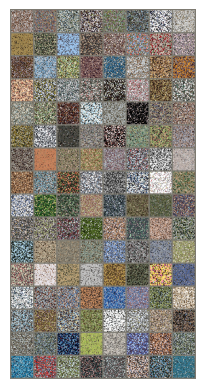

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [61]:
# visualized the effects of pixel shuffle
images_pixelshuffled = shuffle_pixels(images)
print(images_pixelshuffled.shape)
imshow(torchvision.utils.make_grid(images_pixelshuffled))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

In [62]:
# Create a training and test function that supports the shuffling of pixels, either fixed and shared among the entire dataset or newly generated for each batch

def train_one_epoch_pixelshuffled(
    model: nn.Module,
    optimizer: OptimizerTemplate,
    loss_module,
    data_loader,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
) -> Tuple[float, int]:
    true_preds, count = 0.0, 0
    model.train()
    for imgs, labels in data_loader:
        # TODO: 2 points - Implement training loop with training on classification
        imgs = shuffle_pixels(imgs, shuffle_idx_shared)
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
        preds = model(imgs)
        loss = loss_module(preds, labels)
        loss.backward()
        optimizer.step()
        true_preds += (preds.argmax(dim=-1) == labels).sum()
        count += labels.shape[0]

        #raise NotImplementedError
        # Record statistics during training
    train_acc = true_preds / count
    return train_acc

In [63]:
@torch.no_grad()
def test_model_pixelshuffled(
    model: nn.Module,
    data_loader,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
) -> float:
    # TODO: 2 points -- Test model and return accuracy
    model.eval()
    true_preds, count =0.0,0.0
    for imgs, labels in data_loader:
        imgs = shuffle_pixels(imgs, shuffle_idx_shared)
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)  # Forward pass
        true_preds += (preds.argmax(dim=-1) == labels).sum()
        count += labels.shape[0]

    accuracy = true_preds / count if count > 0 else 0.0
    return accuracy
    #raise NotImplementedError


In [64]:
def train_model_pixelshuffled(
    model,
    optimizer,
    loss_module,
    train_data_loader,
    val_data_loader,
    num_epochs=25,
    model_name="MyMLP_pixelshuffled",
    shuffle_idx_shared: Optional[torch.Tensor] = None,
):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_acc = train_one_epoch_pixelshuffled(model, optimizer, loss_module, train_data_loader, shuffle_idx_shared=shuffle_idx_shared)

        if epoch % 5 == 0 or epoch == num_epochs:
            # Evaluate the model and save if best
            acc = test_model_pixelshuffled(model, val_data_loader, shuffle_idx_shared=shuffle_idx_shared)
            if acc > best_val_acc:
                best_val_acc = acc
                save_model(model, model_name, CHECKPOINT_PATH)

            print(
                f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )

    # Load best model after training
    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model

In [66]:
# Create model, optimizer, and start training on fixed shuffling of pixels
model_mlp_pixelshuffled_shared = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp_pixelshuffled_shared.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

# TODO: 2 points -- Create a shared: shuffle_idx
shuffle_idx = torch.randperm(input_dim)
#raise NotImplementedError

model_mlp_pixelshuffled_shared = train_model_pixelshuffled(
    model_mlp_pixelshuffled_shared,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myMLP_ReLU_pixelshuffled_shared",
    shuffle_idx_shared=shuffle_idx,
)

[Epoch  6] Training accuracy: 57.14%, Validation accuracy: 52.74%, Best validation accuracy: 52.74%


In [67]:
# Create model, optimizer, and start training on a new shuffling of pixels per batch/image
model_mlp_pixelshuffled_batch = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp_pixelshuffled_batch.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

model_mlp_pixelshuffled_batch = train_model_pixelshuffled(
    model_mlp_pixelshuffled_batch,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myMLP_ReLU_pixelshuffled_batch",
    shuffle_idx_shared=None,
)

[Epoch  6] Training accuracy: 25.78%, Validation accuracy: 25.96%, Best validation accuracy: 25.96%


What results do you observe? What does this tell us about the MLP being aware of the image structure? Add your results and observations below.

* TODO: 2 points -- write down your observations
* When we shuffle the image pixels, the accuracy decreases. That means that the MLP doesn't preserve the spatial structures of images (as seen in the picture for shuffle), therefore more number of predictions are incorrect.
* Without shuffle the accuracy is almost 51%(without improvising) but with shuffled, the accuracy is almost 26% which shows its reduced by 50% dipicting poor performance.
* The MLP is not aware of the image structure.


## Part 3: Implementing the ConvNet

We will repeat the experiments in Part 2, but with a ConvNet.

### Part 3.1: Vanilla ConvNet

Let's start with a simple LeNet like ConvNet, consisting of a number of convolution blocks (e.g., two Conv+ReLU+MaxPool blocks) followed by a MLP consisting of two hidden layers.

In [68]:
class ConvNet(nn.Module):
    def __init__(self, in_chans: int=3, base_dims: int=32, num_classes:int=10, act_layer=nn.ReLU)->None:
        super().__init__()
        # TODO: 2 points -- write code for two Conv+ReLU+MaxPool blocks
        self.conv = nn.Sequential(nn.Conv2d(in_chans, base_dims, kernel_size=3, padding=1), act_layer(), nn.MaxPool2d(kernel_size=2, stride=2) ,
                                  nn.Conv2d(base_dims, base_dims*2, kernel_size=3, padding=1), act_layer(), nn.MaxPool2d(kernel_size=2, stride=2) )
        #raise NotImplementedError


        self.mlp = MLP(input_dim=base_dims*2, num_classes=num_classes, hidden_dims=[base_dims*4, base_dims*2], act_layer=act_layer)

    def forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=(2, 3))
        x = self.mlp(x)
        return x

In [69]:
# Create model, optimizer, and start training

model_convnet = ConvNet(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

print(f"model convnet created: {count_parameters(model_convnet):05.3f}M")
model_convnet = train_model(
    model_convnet,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myConvNet_ReLU",
)

model convnet created: 0.037M
[Epoch  6] Training accuracy: 40.95%, Validation accuracy: 43.50%, Best validation accuracy: 43.50%


In [70]:
# Test best model on test set
vanilla_convnet_test_acc = test_model(model_convnet, test_loader)
print(f"Test accuracy: {vanilla_convnet_test_acc*100.0:05.2f}%")

Test accuracy: 43.84%


Note: This also came between 41-43 but I re-ran and it increased, if you run the empty file you will get those results again
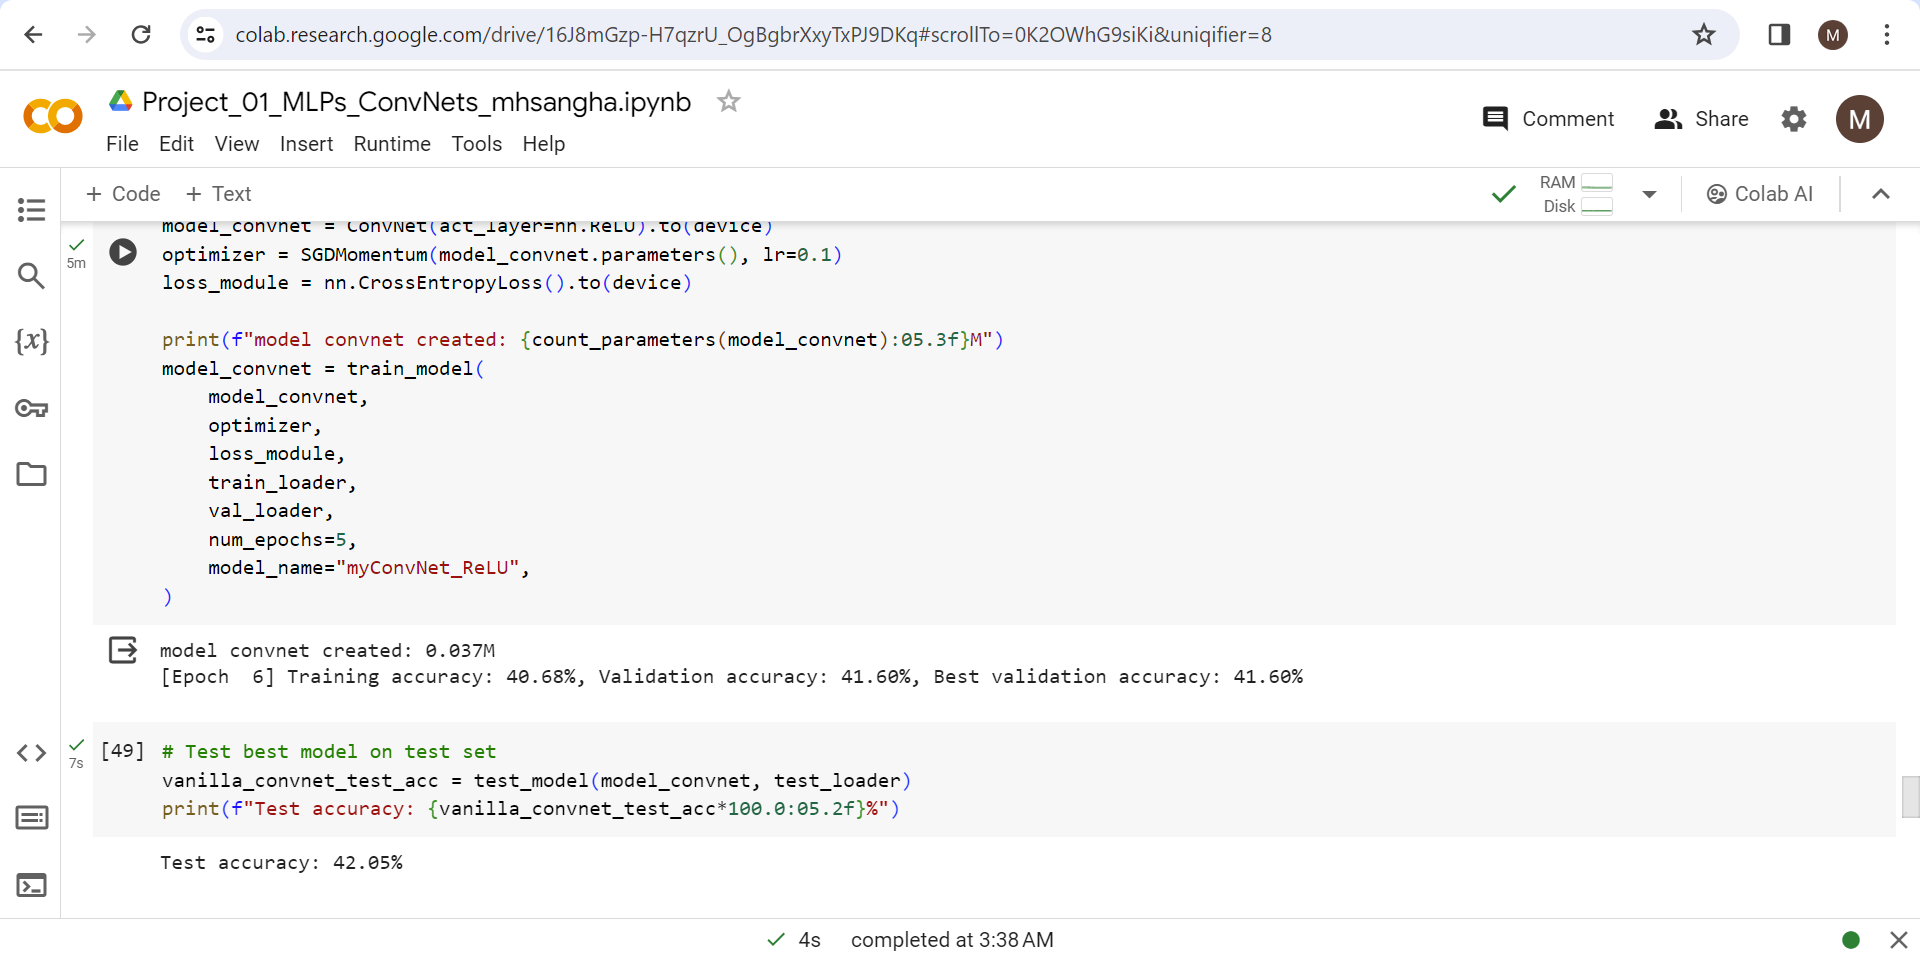

You will observe accuracy around $\sim41-43\%$, worse than the vanilla MLP. Next, we will try to address the performance issue by modifying the specifications of ConvNets.

### Part 3.2: Improving the ConvNet

Similar to Part 2.2. Please explore how to redesign your ConvNet to improve the performance.

In [75]:
# TODO: 10 points -- Improve the model and list the changes as code comments.
# You may try different changes (e.g. those suggested in Part 2.2) individually or combine them.
# You do not need to explore all the four suggestions above.
# You can create as many code blocks as you need.

# add a layer and batch normalization
class Im_ConvNet(nn.Module):
    def __init__(self, in_chans: int=3, base_dims: int=32, num_classes:int=10, act_layer=nn.ReLU)->None:
        super().__init__()
        # TODO: 2 points -- write code for two Conv+ReLU+MaxPool blocks
        self.conv = nn.Sequential(nn.Conv2d(in_chans, base_dims, kernel_size=3, padding=1),nn.BatchNorm2d(base_dims), act_layer(), nn.MaxPool2d(kernel_size=2, stride=2) ,
                                  nn.Conv2d(base_dims, base_dims*2, kernel_size=3, padding=1),nn.BatchNorm2d(base_dims*2), act_layer(), nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(base_dims*2, base_dims*4, kernel_size=3, padding=1), nn.BatchNorm2d(base_dims*4), act_layer(), nn.MaxPool2d(kernel_size=2, stride=2) )
        #raise NotImplementedError


        self.mlp = MLP(input_dim=base_dims*4, num_classes=num_classes, hidden_dims=[base_dims*8, base_dims*4], act_layer=act_layer)

    def forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=(2, 3))
        x = self.mlp(x)
        return x
#raise NotImplementedError

In [76]:
im_model_convnet = Im_ConvNet(act_layer=nn.ReLU).to(device)
im_optimizer = SGDMomentum(im_model_convnet.parameters(), lr=0.1)
im_loss_module = nn.CrossEntropyLoss().to(device)

print(f"Improved model convnet created: {count_parameters(im_model_convnet):05.3f}M")
im_model_convnet = train_model(
    im_model_convnet,
    im_optimizer,
    im_loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="my_Im_ConvNet_ReLU",
)

Improved model convnet created: 0.161M
[Epoch  6] Training accuracy: 66.67%, Validation accuracy: 61.38%, Best validation accuracy: 61.38%


In [90]:
# Test best model on test set
im_vanilla_convnet_test_acc = test_model(im_model_convnet, test_loader)
print(f"Test accuracy: {im_vanilla_convnet_test_acc*100.0:05.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test accuracy: 66.73%


### Part 3.3: Testing if ConvNets can address the limitations of MLP

Similar to Part 2.3. Test your improved ConvNet to compare the results with those in Part 2.3.

In [77]:
# TODO: 2 points -- Train your best ConvNet using data with a shared pixel shuffle and check the accuracy for training, validation and testing datasets
model_cn_pixelshuffled_shared = Im_ConvNet(act_layer=nn.ReLU).to(device)
cn_optimizer = SGDMomentum(model_cn_pixelshuffled_shared.parameters(), lr=0.1)
cn_loss_module = nn.CrossEntropyLoss().to(device)

# TODO: 2 points -- Create a shared: shuffle_idx
cn_shuffle_idx = torch.randperm(input_dim)
#raise NotImplementedError

model_cn_pixelshuffled_shared = train_model_pixelshuffled(
    model_cn_pixelshuffled_shared,
    cn_optimizer,
    cn_loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myCN_ReLU_pixelshuffled_shared",
    shuffle_idx_shared=cn_shuffle_idx,
)

[Epoch  6] Training accuracy: 67.51%, Validation accuracy: 64.86%, Best validation accuracy: 64.86%


In [78]:
# TODO: 2 points -- Train your best ConvNet using data with a # TODO: Train your best ConvNet using data with a per-batch pixel shuffle and check the accuracy for training, validation and testing datasets pixel shuffle and check the accuracy for training, validation and testing datasets
# Create model, optimizer, and start training on a new shuffling of pixels per batch/image
model_cn_pixelshuffled_batch = Im_ConvNet(act_layer=nn.ReLU).to(device)
cn_optimizer = SGDMomentum(model_cn_pixelshuffled_batch.parameters(), lr=0.1)
cn_loss_module = nn.CrossEntropyLoss().to(device)

model_cn_pixelshuffled_batch = train_model_pixelshuffled(
    model_cn_pixelshuffled_batch,
    cn_optimizer,
    cn_loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myCN_ReLU_pixelshuffled_batch",
    shuffle_idx_shared=None,
)

[Epoch  6] Training accuracy: 34.61%, Validation accuracy: 34.74%, Best validation accuracy: 34.74%


## Part 4: Fitting Noise

We will re-create a training dataset with ground-truth labels shuffled (i.e., labels become noises). Then, we train our MLPs and ConvNets to check the training accuracy. If they could do a good job, it means that there are potential risks of fitting noises of deep neural networks, and we shall be careful in monitoring the data quality in supervised training.

### Shuffle the Ground-Truth Labels

In [79]:
# TODO: 2 points -- Create a training dataset with ground-truth labels shuffled
#raise NotImplementedError
noise_train_dataset = data.dataset.Subset(main_dataset, indices=torch.randperm(len(main_dataset.targets)))

# Create data loaders for later
noise_train_loader = data.DataLoader(
    noise_train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=3,
)


### Verify labels are shuffled

In [80]:
noise_dataiter = iter(noise_train_loader)
noise_images, noisey_labels = next(noise_dataiter)

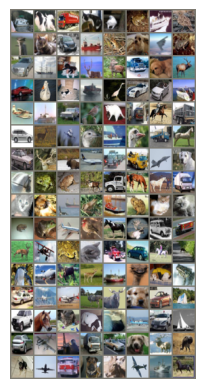

Noisy labels (row 0):  ship  dog   truck cat   bird  frog  ship  bird 
Noisy labels (row 1):  bird  cat   car   ship  frog  dog   plane frog 
Noisy labels (row 2):  car   ship  dog   deer  deer  truck dog   deer 
Noisy labels (row 3):  car   bird  cat   ship  bird  car   car   ship 
Noisy labels (row 4):  plane ship  car   bird  cat   truck horse truck
Noisy labels (row 5):  car   deer  plane bird  ship  bird  truck horse
Noisy labels (row 6):  car   deer  deer  plane truck truck plane dog  
Noisy labels (row 7):  horse frog  frog  deer  truck horse horse truck
Noisy labels (row 8):  cat   dog   ship  frog  ship  frog  cat   cat  
Noisy labels (row 9):  frog  frog  plane bird  horse deer  car   truck
Noisy labels (row 10):  deer  plane frog  cat   truck car   horse deer 
Noisy labels (row 11):  bird  plane deer  deer  ship  bird  dog   frog 
Noisy labels (row 12):  car   plane plane bird  deer  dog   car   ship 
Noisy labels (row 13):  car   horse cat   dog   cat   plane car   ship 
No

In [81]:
imshow(torchvision.utils.make_grid(noise_images))
for i in range(0, len(noisey_labels), 8):
    print(
        f"Noisy labels (row {i//8}): ",
        " ".join(f"{classes[noisey_labels[i+j]]:5s}" for j in range(8)),
    )

### Training MLPs and ConvNets on the noisy datasets

In [84]:
# TODO: 5 points -- Train your best MLP and check the training accuracy
# TODO: 5 points -- Train your best MLP and check the training accuracy
noise_model_mlp = new_MLP(act_layer=nn.LeakyReLU).to(device)
noise_optimizer = SGDMomentum(noise_model_mlp.parameters(), lr=0.12, momentum =0.9) # you may tune lr
noise_loss_module = nn.CrossEntropyLoss().to(device)

print(f'model mlp created: {count_parameters(noise_model_mlp):05.3f}M')
noise_model_mlp=train_model(noise_model_mlp, noise_optimizer, noise_loss_module, noise_train_loader, val_loader, num_epochs=13, model_name="my_noise_MLP_ReLU")

model mlp created: 3.847M
[Epoch  6] Training accuracy: 61.59%, Validation accuracy: 67.74%, Best validation accuracy: 67.74%
[Epoch 11] Training accuracy: 74.23%, Validation accuracy: 80.24%, Best validation accuracy: 80.24%
[Epoch 14] Training accuracy: 79.80%, Validation accuracy: 84.76%, Best validation accuracy: 84.76%


In [82]:
# TODO: 5 points -- Train your best ConvNet and check the training accuracy
im_model_convnet = Im_ConvNet(act_layer=nn.ReLU).to(device)
im_optimizer = SGDMomentum(im_model_convnet.parameters(), lr=0.1)
im_loss_module = nn.CrossEntropyLoss().to(device)

print(f"Improved model convnet created: {count_parameters(im_model_convnet):05.3f}M")
im_model_convnet = train_model(
    im_model_convnet,
    im_optimizer,
    im_loss_module,
    noise_train_loader,
    val_loader,
    num_epochs=5,
    model_name="my_Im_ConvNet_ReLU",
)

Improved model convnet created: 0.161M
[Epoch  6] Training accuracy: 67.28%, Validation accuracy: 69.60%, Best validation accuracy: 69.60%


## Conclusion

You have reached the end of the practical, congratulations! Now, you should have a good idea of what it means to train a MLP, how we can use neural networks to perform image classification, what aspects there are to improve a networks performance, and what limitations and risks there are.